## Workshop 5: Optimisation Under Uncertainty

### 1. Installing and Importing Packages 

We first need to pull in all the packages we will be using. Pyomo is a Python-based, open-source optimization modelling language with a diverse set of optimization capabilities. For more information, see the Pyomo [documentation](https://pyomo.readthedocs.io/en/stable/).

In [2]:
# Only run once at the start
!pip install -q pyomo
!pip install -q matplotlib

In [2]:
import matplotlib.pyplot as plt
from pyomo.environ import *
import numpy as np
from ipywidgets import FloatSlider, interact
import platform
import scipy.stats as stats

# Ipopt solver setup for Windows or Linux
def setup_solver():
    os_name = platform.system()
    if os_name == "Windows":
        return "solver/ipopt.exe"
    elif os_name == "Linux":
        !chmod +x "solver/ipopt"
        return "solver/ipopt"


solver_executable = setup_solver()

In [129]:
# Parameters for the EWibull distribution
alpha = 3  # Scale parameter
beta = 2      # Shape parameter

# Function to compute the PDF of the EWibull distribution
def ewibull_pdf(x, alpha, beta):
    if x < 0:
        return 0
    else:
        return (beta / alpha) * (x / alpha)**(beta - 1) * np.exp(-(x / alpha)**beta)

# Sample from the EWibull distribution
N_SAMPLES = 100
sample_list = []
for _ in range(N_SAMPLES):
    a = stats.weibull_min(beta, scale=alpha).rvs()  # Sample using the Weibull distribution
    p_a = ewibull_pdf(a, alpha, beta)  # PDF at the sample
    sample_list.append((a, p_a))

# Define the x range for the EWibull distribution
x = np.linspace(0, 20, 1000)  # Adjust the range based on your scale
y = [ewibull_pdf(i, alpha, beta) for i in x]  # Calculate PDF values

In [137]:
# Create a Pyomo model
model = ConcreteModel()

# Variables
model.x1 = Var(bounds=(1, 1000), domain=PositiveReals)
model.x2 = Var(domain=Reals)
model.y = Var(range(N_SAMPLES), bounds=(0, 1), within=Binary)

# Objective Function
@model.Objective(sense=minimize)
def objective_rule(model):
    return sum((a * p_a * model.x1 + model.x2) for a, p_a in sample_list)

M = 100
# Loop to add multiple constraints based on uncertain values
def constraint_rule(model, i):
    a, _ = sample_list[i]  # Get 'a' from the sample_list
    return a * model.x1 + model.x2 >= -3 + M * (1-model.y[i])

# Create constraints using a loop
model.constraints = ConstraintList()
for i in range(N_SAMPLES):
    model.constraints.add(constraint_rule(model, i))

# Sum of y constraint
model.sum_y_constraint = Constraint(expr=sum(model.y[i] for i in range(N_SAMPLES)) >= 90)

# To solve the model
solver = SolverFactory('gurobi')  # Ensure Gurobi is installed
results = solver.solve(model)


In [138]:
print(f"x1: {model.x1.value}")
print(f"x2: {model.x2.value}")
for i in range(N_SAMPLES):
    if model.y[i].value != 1:
        print(f"y[{i}]: {model.y[i].value}")

print(model.objective_rule())

x1: 1.0
x2: -3.194335070692001
-271.0798962375953


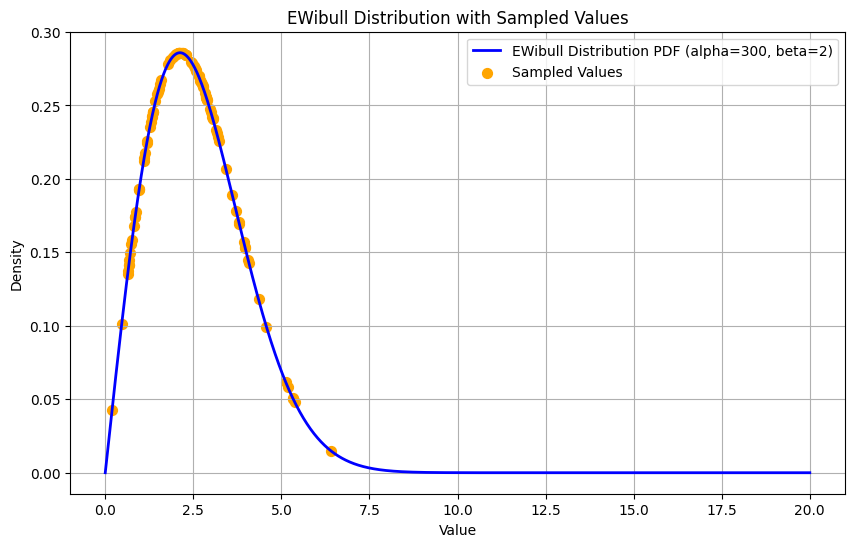

In [139]:
# Extract sampled values and their corresponding PDF values
sample_values = [a for a, _ in sample_list]
sample_pdf_values = [p_a for _, p_a in sample_list]  # PDF values at sampled points

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='EWibull Distribution PDF (alpha=300, beta=2)', color='blue', linewidth=2)
plt.scatter(sample_values, sample_pdf_values, color='orange', label='Sampled Values', marker='o', s=50)  # Plot samples at their PDF values
plt.title('EWibull Distribution with Sampled Values')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()
